* target network
* experienced (prioritized) replay
* structure actions

In [48]:
from __future__ import print_function 
experiment_setup_name = "tutorial.gym.atari.spaceinvaders-v0.cnn"


#gym game title
GAME_TITLE = 'SpaceInvaders-v0'
# GAME_TITLE = 'CartPole-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 5

#how long is one replay session from a batch
#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 10


#theano device selection. GPU is, as always, in preference, but not required
%env THEANO_FLAGS='device=cpu'

env: THEANO_FLAGS='device=cpu'


In [204]:
import gym

In [207]:
gym.envs.

[EnvSpec(Asteroids-ramDeterministic-v1),
 EnvSpec(Asteroids-ramDeterministic-v0),
 EnvSpec(RoadRunner-ramDeterministic-v0),
 EnvSpec(RoadRunner-ramDeterministic-v1),
 EnvSpec(Gopher-ramDeterministic-v1),
 EnvSpec(Gopher-ramDeterministic-v0),
 EnvSpec(DoubleDunk-ramDeterministic-v1),
 EnvSpec(DoubleDunk-ramDeterministic-v0),
 EnvSpec(Robotank-ram-v1),
 EnvSpec(Robotank-ram-v0),
 EnvSpec(CartPole-v0),
 EnvSpec(CartPole-v1),
 EnvSpec(Gopher-ram-v0),
 EnvSpec(Gopher-ram-v1),
 EnvSpec(Pooyan-ram-v1),
 EnvSpec(Pooyan-ram-v0),
 EnvSpec(Alien-ramNoFrameskip-v1),
 EnvSpec(CarRacing-v0),
 EnvSpec(SpaceInvaders-ram-v0),
 EnvSpec(YarsRevenge-ramDeterministic-v0),
 EnvSpec(YarsRevenge-ramDeterministic-v1),
 EnvSpec(SpaceInvadersDeterministic-v0),
 EnvSpec(SpaceInvadersDeterministic-v1),
 EnvSpec(DoubleDunk-ram-v0),
 EnvSpec(DoubleDunk-ram-v1),
 EnvSpec(VideoPinballDeterministic-v0),
 EnvSpec(Centipede-v0),
 EnvSpec(Centipede-v1),
 EnvSpec(VideoPinballDeterministic-v1),
 EnvSpec(Pitfall-ramNoFramesk

# This tutorial is a showcase on how to use AgentNet for OpenAI Gym environments


* Space Invaders game as an example
* Training a simple lasagne neural network for Q_learning objective
 * This example can be easily modified to use convolutional networks and/or recurrent agent memory. 
 
* Training via simple experience replay (explained below)
* Only using utility recurrent layers for simplicity of this example
 * but adding a few RNNs or GRUs shouldn's be a problem
* the network is trained with a simple one-step Q-learning for simplicity


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

## New to AgentNet and Lasagne?
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb


# Experiment setup
* Here we basically just load the game

In [49]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [52]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
# plt.imshow(atari.render(mode='rgb_array'))
# http://newsight.tistory.com/231 -- possible solution to rendering.

[2016-09-21 09:17:02,118] Making new env: SpaceInvaders-v0


array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ..., 
       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ..., 
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ..., 
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ..., 
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

In [60]:
print(atari.action_space)
print(atari.get_action_meanings())

Discrete(6)
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [56]:
atari.observation_space

Box(210, 160, 3)

In [152]:
for i in range(50):
    observation, reward, done, info = atari.step(1)

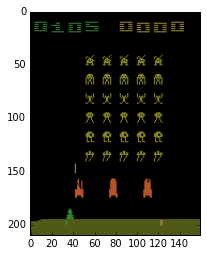

In [153]:
plt.imshow(observation)

In [125]:
reward

0.0

In [126]:
done

False

In [127]:
info

{}

### Game Parameters
* observation dimensions, actions, etc

In [154]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print(action_names)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [155]:
# (batch_size, height, width, num_channels)
observation_shape

(None, 210, 160, 3)

In [156]:
del atari

# agent setup step by step
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * chooses what action to take given Q-values
   * in this case, the resolver has epsilon-greedy policy
   
   
We are going to build something of this shape:

(one can assume that the 'time' goes from left to right, inputs are at the bottom and outputs go to the top)



![window_dqn_scheme](http://s32.postimg.org/yy5q3wadx/window_dqn.png)
  




##### Agent observations

* Here you define where observations (game images) appear in the network

In [157]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer

In [158]:
#image observation at current tick goes here
observation_layer = InputLayer(observation_shape,
                               name="images input")


#reshape to [batch, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))

observation_reshape = lasagne.layers.Pool2DLayer(observation_reshape,(2,2),mode='average_inc_pad')

In [161]:
print(lasagne.layers.get_output_shape(observation_layer))
print(lasagne.layers.get_output_shape(observation_reshape))

(None, 210, 160, 3)
(None, 3, 105, 80)


  
### Agent memory states
 * Here you can define arbitrary transitions between "previous state" variables and their next states
 * The rules are
   * previous states must be input layers
   * next states must have same shape as previous ones
   * otherwise it can be any lasagne network
   * AgentNet.memory has several useful layers
   
 * During training and evaluation, your states will be updated recurrently
   * next state at t=1 is given as previous state to t=2
 
 * Finally, you have to define a dictionary mapping new state -> previous state


### In this demo
Since we have almost fully observable environment AND we want to keep baseline simple, we shall use no recurrent units.
However, Atari game environments are known to have __flickering__ effect where some sprites are shown only on odd frames and others on even ones - that was used to optimize performance at the time.
To compensate for this, we shall use the memory layer called __WindowAugmentation__ which basically maintains a K previous time steps of what it is fed with.

One can try to use
 * GRU - `from agentnet.memory import GRUMemoryLayer`
 * RNN - `from agentnet.memory import RNNCell`
 * any custom lasagne layers that compute new memory states


In [162]:

#memory
#using simple window-based memory that stores several states
#the SpaceInvaders environment does not need any more as it is almost fully-observed
from agentnet.memory import WindowAugmentation


window_size = 3


#prev state input
prev_window = InputLayer((None,window_size)+tuple(observation_reshape.output_shape[1:]),
                        name = "previous window state")


#our window
window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name = "new window state")



memory_dict = {window:prev_window}



In [163]:
lasagne.layers.get_output_shape(window)

(None, 3, 3, 105, 80)

##### Neural network body
Our strategy, again:
 * take pixel-wise maximum over the window
 * apply some layers
 * use output layer to predict Q-values(see next)

In [164]:
from lasagne.layers import DropoutLayer,DenseLayer, ExpressionLayer
#you may use any other lasagne layers, including convolutions, batch_norms, maxout, etc

#pixel-wise maximum over the temporal window (to avoid flickering)
window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,)+window.output_shape[2:])



#a simple lasagne network (try replacing with any other lasagne network and see what works best)    
nn = lasagne.layers.Conv2DLayer(window_max,32,filter_size=8,stride=(4,4), name='cnn0')
nn = lasagne.layers.Conv2DLayer(nn,64,filter_size=8,stride=(4,4), name='cnn1 ыть')

#nn = DropoutLayer(nn,name = "dropout", p=0.05) #will get deterministic during evaluation
nn = DenseLayer(nn,num_units=256,name='dense1')


#WARNING! if your network is computing too slowly, try decreasing the amount of neurons


##### Agent policy and action picking
* Since we are training a deep Q-network, we need it to predict Q-values and take actions.
* Hence we define a lasagne layer that is used for action output

* To pick actions, we use an epsilon-greedy resolver
  * Note that resolver outputs particular action IDs and not probabilities.
  * These actions are than sent into the environment

In [165]:
#q_eval
q_eval = DenseLayer(nn,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")

#resolver
from agentnet.resolver import EpsilonGreedyResolver
resolver = EpsilonGreedyResolver(q_eval,name="resolver")



In [166]:
from agentnet.target_network import TargetNetwork

targetnet = TargetNetwork(q_eval,(window_max))
q_eval_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [1]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layer,
              memory_dict,
              [q_eval,q_eval_old],resolver)


In [168]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[cnn0.W,
 cnn0.b,
 cnn1 ыть.W,
 cnn1 ыть.b,
 dense1.W,
 dense1.b,
 QEvaluator.W,
 QEvaluator.b]

# Agent step function
* computes action and next state given observation and prev state
* written in a generic way to support any recurrences, windows, LTMs, etc

In [171]:
#compile theano graph for one step decision making
applier_fun = agent.get_react_function()

#a nice pythonic interface
def step(observation, prev_memories = 'zeros', batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype='float32') 
                         for mem in agent.agent_states]
    res = applier_fun(np.array(observation),*prev_memories)
    action = res[0]
    memories = res[1:]
    return action,memories

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [172]:
from agentnet.experiments.openai_gym.pool import GamePool

pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)


[2016-09-21 15:10:15,973] Making new env: SpaceInvaders-v0
[2016-09-21 15:10:16,029] Making new env: SpaceInvaders-v0
[2016-09-21 15:10:16,076] Making new env: SpaceInvaders-v0
[2016-09-21 15:10:16,128] Making new env: SpaceInvaders-v0
[2016-09-21 15:10:16,212] Making new env: SpaceInvaders-v0


In [173]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(step,50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

[['FIRE' 'FIRE' 'LEFT' 'FIRE' 'RIGHT']
 ['FIRE' 'FIRE' 'FIRE' 'FIRE' 'FIRE']
 ['FIRE' 'FIRE' 'FIRE' 'FIRE' 'FIRE']]
CPU times: user 3.64 s, sys: 4 s, total: 7.64 s
Wall time: 4.83 s


# experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [180]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.agent_states)

In [181]:
def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    #get interaction sessions
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(step,n_steps=n_steps)
        
    #load them into experience replay environment
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
    

In [182]:
#load first  sessions
update_pool(env,pool,replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [184]:
#get agent's Qvalues obtained via experience replay
_,_,_,_,(qvalues_seq,qvalues_seq_old) = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True,
)


#The "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - observation sequences - whatever agent recieved at observation input(s) on each tick
#third - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now.
* Later you can try:
 * SARSA - simpler on-policy algorithms
 * N-step q-learning (requires n_steps parameter)
 * Advantage Actor-Critic (requires state values and probabilities instead of Q-values)


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [185]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later




#IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = env.rewards
#For SpaceInvaders, however, not scaling rewards is at least working


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        env.actions[0],
                                                        scaled_reward_seq,
                                                        env.is_alive,
                                                        Qvalues_target=qvalues_seq_old,
                                                        gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()

In [186]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-5

In [187]:
loss = mse_loss + reg_l2

In [188]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [189]:
#mean session reward
mean_session_reward = env.rewards.sum(axis=1).mean()

# Compile train and evaluation functions

In [190]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# Session visualization tools

Just a helper function that draws current game images.

In [191]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.games[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    

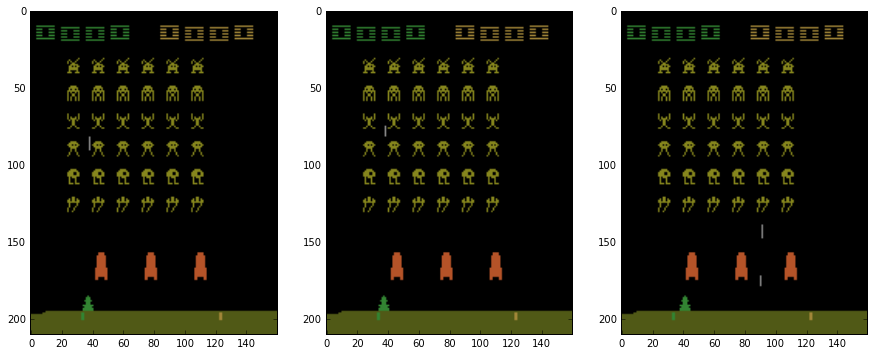

In [192]:
#visualize untrained network performance (which is mostly random)
display_sessions()

# Training loop

In [193]:
import os

In [194]:
from agentnet.display import Metrics
score_log = Metrics()

In [195]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 5,loss 12.46923, epsilon 0.49776, rewards: ( e-greedy 0.10000, greedy 0.20000) 
rec 12.465 reg 0.005
epoch 10,loss 6.06800, epsilon 0.49552, rewards: ( e-greedy 0.09000, greedy 0.18000) 
rec 6.063 reg 0.005
epoch 15,loss 10.42698, epsilon 0.49330, rewards: ( e-greedy 0.38100, greedy 0.46200) 
rec 10.422 reg 0.005
epoch 20,loss 5.15635, epsilon 0.49109, rewards: ( e-greedy 0.34290, greedy 0.81580) 
rec 5.152 reg 0.005
epoch 25,loss 5.67033, epsilon 0.48889, rewards: ( e-greedy 0.30861, greedy 0.73422) 
rec 5.666 reg 0.005
epoch 30,loss 5.77127, epsilon 0.48670, rewards: ( e-greedy 0.57775, greedy 0.86080) 
rec 5.767 reg 0.005
epoch 35,loss 15.86978, epsilon 0.48452, rewards: ( e-greedy 1.01997, greedy 0.77472) 
rec 15.865 reg 0.005
epoch 40,loss 4.05343, epsilon 0.48236, rewards: ( e-greedy 1.01798, greedy 1.09725) 
rec 4.049 reg 0.005
epoch 45,loss 5.00214, epsilon 0.48020, rewards: ( e-greedy 1.01618, greedy 1.48752) 
rec 4.998 reg 0.005
epoch 50,loss 3.48358, epsilon 0.47805, r

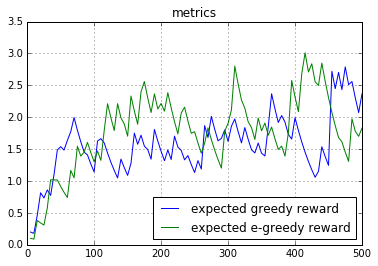

Random session examples


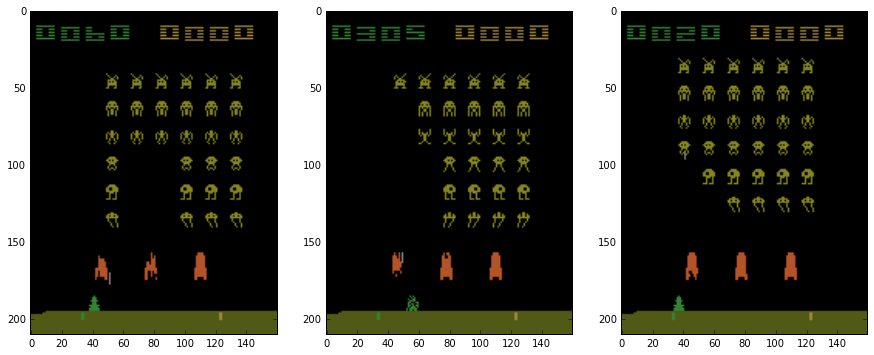

epoch 505,loss 3.00568, epsilon 0.32158, rewards: ( e-greedy 1.64802, greedy 2.12968) 
rec 3.001 reg 0.005
epoch 510,loss 27.79128, epsilon 0.32022, rewards: ( e-greedy 2.58322, greedy 2.41671) 
rec 27.787 reg 0.005
epoch 515,loss 1.38182, epsilon 0.31888, rewards: ( e-greedy 2.32490, greedy 2.77504) 
rec 1.377 reg 0.005
epoch 520,loss 1.43747, epsilon 0.31753, rewards: ( e-greedy 2.09241, greedy 2.49753) 
rec 1.433 reg 0.005
epoch 525,loss 9.06828, epsilon 0.31620, rewards: ( e-greedy 2.28317, greedy 2.24778) 
rec 9.064 reg 0.005
epoch 530,loss 4.21145, epsilon 0.31487, rewards: ( e-greedy 2.15485, greedy 2.72300) 
rec 4.207 reg 0.005
epoch 535,loss 2.27629, epsilon 0.31355, rewards: ( e-greedy 2.03936, greedy 2.65070) 
rec 2.272 reg 0.005
epoch 540,loss 3.72614, epsilon 0.31224, rewards: ( e-greedy 1.93543, greedy 2.88563) 
rec 3.722 reg 0.005
epoch 545,loss 3.34465, epsilon 0.31093, rewards: ( e-greedy 1.74189, greedy 2.59707) 
rec 3.340 reg 0.005
epoch 550,loss 20.17059, epsilon 0.

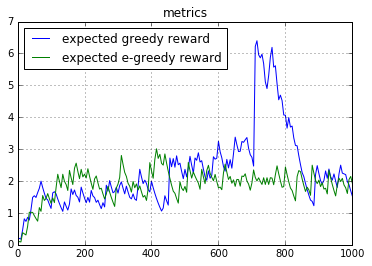

Random session examples


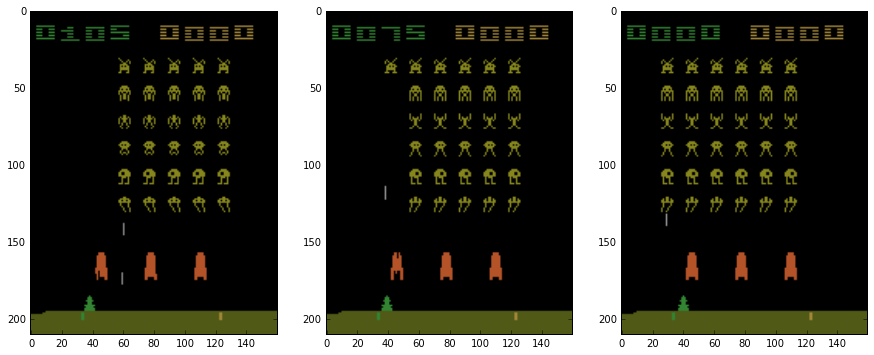

epoch 1005,loss 6.34281, epsilon 0.21472, rewards: ( e-greedy 1.93641, greedy 1.87273) 
rec 6.338 reg 0.005
epoch 1010,loss 2.96711, epsilon 0.21390, rewards: ( e-greedy 1.74277, greedy 1.98545) 
rec 2.962 reg 0.005
epoch 1015,loss 10.02434, epsilon 0.21308, rewards: ( e-greedy 1.96849, greedy 1.78691) 
rec 10.020 reg 0.005
epoch 1020,loss 8.07941, epsilon 0.21227, rewards: ( e-greedy 2.17164, greedy 1.90822) 
rec 8.075 reg 0.005
epoch 1025,loss 3.89081, epsilon 0.21146, rewards: ( e-greedy 2.15448, greedy 1.81740) 
rec 3.886 reg 0.005
epoch 1030,loss 1.88118, epsilon 0.21065, rewards: ( e-greedy 1.93903, greedy 1.63566) 
rec 1.877 reg 0.005
epoch 1035,loss 2.58868, epsilon 0.20985, rewards: ( e-greedy 1.74513, greedy 1.47209) 
rec 2.584 reg 0.005
epoch 1040,loss 2.42087, epsilon 0.20905, rewards: ( e-greedy 1.77061, greedy 1.32488) 
rec 2.416 reg 0.005
epoch 1045,loss 17.87024, epsilon 0.20826, rewards: ( e-greedy 2.19355, greedy 1.19239) 
rec 17.866 reg 0.005
epoch 1050,loss 3.73796,

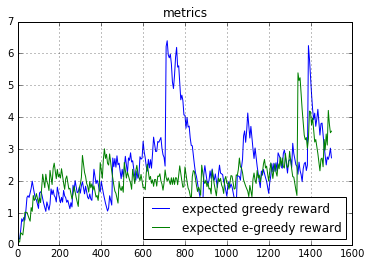

Random session examples


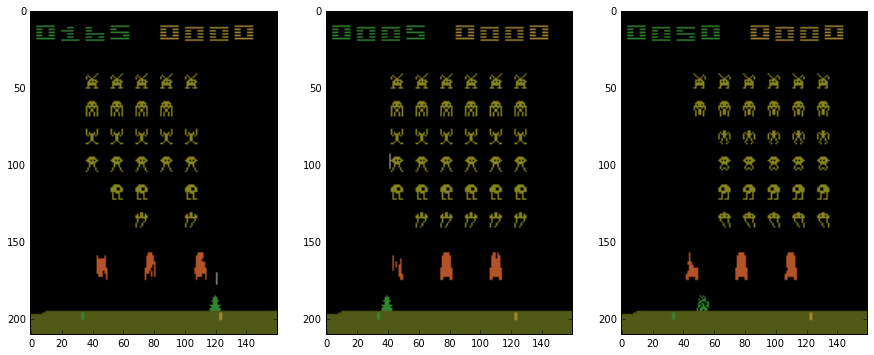

epoch 1505,loss 1.89668, epsilon 0.14991, rewards: ( e-greedy 3.20635, greedy 2.45436) 
rec 1.892 reg 0.005
epoch 1510,loss 4.21004, epsilon 0.14941, rewards: ( e-greedy 2.88571, greedy 2.20893) 
rec 4.205 reg 0.005
epoch 1515,loss 3.75914, epsilon 0.14891, rewards: ( e-greedy 2.59714, greedy 2.58803) 
rec 3.755 reg 0.005
epoch 1520,loss 2.91286, epsilon 0.14842, rewards: ( e-greedy 2.33743, greedy 2.42923) 
rec 2.908 reg 0.005
epoch 1525,loss 6.10380, epsilon 0.14793, rewards: ( e-greedy 2.40368, greedy 2.28631) 
rec 6.099 reg 0.005
epoch 1530,loss 11.93102, epsilon 0.14744, rewards: ( e-greedy 2.56332, greedy 2.15768) 
rec 11.926 reg 0.005
epoch 1535,loss 2.50207, epsilon 0.14696, rewards: ( e-greedy 2.30698, greedy 2.24191) 
rec 2.497 reg 0.005
epoch 1540,loss 3.07239, epsilon 0.14647, rewards: ( e-greedy 2.07629, greedy 2.61772) 
rec 3.068 reg 0.005
epoch 1545,loss 3.20467, epsilon 0.14599, rewards: ( e-greedy 1.86866, greedy 2.35595) 
rec 3.200 reg 0.005
epoch 1550,loss 7.11350, e

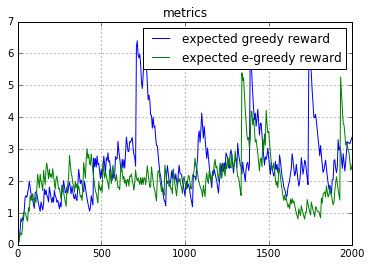

Random session examples


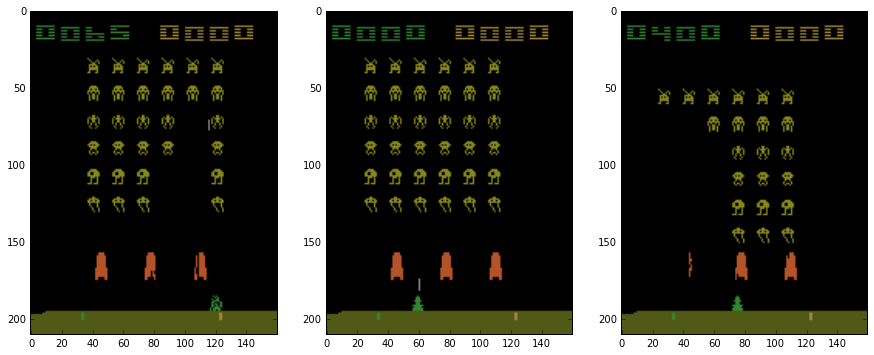

epoch 2005,loss 3.05693, epsilon 0.11060, rewards: ( e-greedy 2.30739, greedy 3.45536) 
rec 3.052 reg 0.005
epoch 2010,loss 11.26723, epsilon 0.11029, rewards: ( e-greedy 2.47665, greedy 3.40982) 
rec 11.263 reg 0.005
epoch 2015,loss 4.42766, epsilon 0.10999, rewards: ( e-greedy 2.42899, greedy 3.06884) 
rec 4.423 reg 0.005
epoch 2020,loss 3.12801, epsilon 0.10969, rewards: ( e-greedy 2.28609, greedy 2.76195) 
rec 3.123 reg 0.005
epoch 2025,loss 13.81579, epsilon 0.10940, rewards: ( e-greedy 2.85748, greedy 3.28576) 
rec 13.811 reg 0.005
epoch 2030,loss 1.72980, epsilon 0.10910, rewards: ( e-greedy 2.57173, greedy 2.95718) 
rec 1.725 reg 0.005
epoch 2035,loss 2.39786, epsilon 0.10881, rewards: ( e-greedy 2.31456, greedy 3.16146) 
rec 2.393 reg 0.005
epoch 2040,loss 5.75838, epsilon 0.10851, rewards: ( e-greedy 2.28310, greedy 2.84532) 
rec 5.754 reg 0.005
epoch 2045,loss 3.09788, epsilon 0.10822, rewards: ( e-greedy 2.15479, greedy 2.56079) 
rec 3.093 reg 0.005
epoch 2050,loss 3.26716,

KeyboardInterrupt: 

In [196]:
%%time

n_epochs = 25000
#25k may take hours to train.
#consider interrupt early.



for i in range(n_epochs):    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%5 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %500 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()

    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

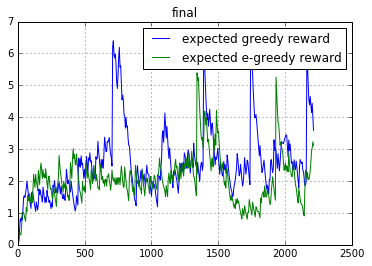

In [197]:
score_log.plot("final")

Random session examples


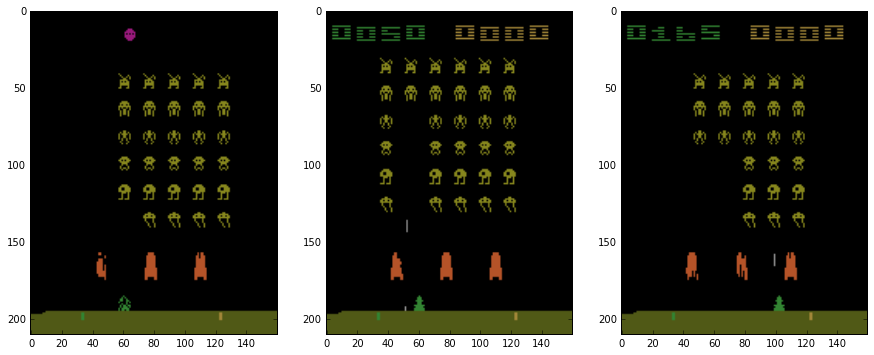

In [198]:
print("Random session examples")
display_sessions()

# Submission
Here we simply run the OpenAI gym submission code and view scores

In [199]:
resolver.epsilon.set_value(0)

In [203]:

save_path = 'AgentNet-simplenet-SpaceInvadersv0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
#subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(10):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories,batch_size=1)
        observation, reward, done, info = subm_env.step(action[0])
        
        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        t+=1

subm_env.monitor.close()

[2016-09-21 15:48:05,600] Making new env: SpaceInvaders-v0
[2016-09-21 15:48:05,638] Creating monitor directory AgentNet-simplenet-SpaceInvadersv0-Recording0
[2016-09-21 15:48:05,705] Starting new video recorder writing to /root/notebooks/AgentNet-simplenet-SpaceInvadersv0-Recording0/openaigym.video.2.57.video000000.mp4
[2016-09-21 15:48:11,512] Starting new video recorder writing to /root/notebooks/AgentNet-simplenet-SpaceInvadersv0-Recording0/openaigym.video.2.57.video000001.mp4


Episode finished after 873 timesteps
Episode finished after 753 timesteps
Episode finished after 665 timesteps
Episode finished after 820 timesteps
Episode finished after 380 timesteps
Episode finished after 1139 timesteps
Episode finished after 843 timesteps


[2016-09-21 15:48:35,226] Starting new video recorder writing to /root/notebooks/AgentNet-simplenet-SpaceInvadersv0-Recording0/openaigym.video.2.57.video000008.mp4


Episode finished after 982 timesteps
Episode finished after 633 timesteps


[2016-09-21 15:48:42,667] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/AgentNet-simplenet-SpaceInvadersv0-Recording0')


Episode finished after 819 timesteps


In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for examples? Try examples/Deep Kung Fu for most of these features


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__